<a href="https://colab.research.google.com/github/Mechanics-Mechatronics-and-Robotics/CV-2025/blob/main/Lab_1_Feature_Extraction_and_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab. \#1. Feature Extraction and Machine Learning

## Problem Statement

The lab deals with comparison of two approaches to machine learning (ML) and computer vision (CV). *The first approach* is processing of hand-designed features, e.g. geometric features of objects in images, with an ML classification model. *The second approach* is using of the ML model for both, the automatic feature extraction and the following classification.

The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples.

The hand-designed features can be extracted with standart tools in [scikit-learn](https://scikit-learn.org/1.5/modules/feature_extraction.html)

## Tasks and Requirements
* Check the [Linghtning framework](https://lightning.ai/docs/pytorch/stable/) (Level Up, Core API, Optional API section of the manual)
* Check the [ClearML](https://clear.ml/docs/latest/docs/integrations/pytorch_lightning/)
* Fill the table in the Results section and fill the Conclusion section

Bonus

* apply a t-SNE model to visualize both, the original images dataset, and the designed table dataset with hand-extracted features from the images

# Preparation of simulation models

## Import and Install Libraries

In [37]:
!pip install pytorch-lightning clearml

In [38]:
#Pytorch modules
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
#sklearn
from sklearn.metrics import confusion_matrix
#Numpy
import numpy as np
#Pandas
import pandas as pd
#Lightning & logging
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
#Data observation
import os
from pathlib import Path
#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
#Logging
from clearml import Task

## Set the Model

### Simulation Settings

Check the current directory

In [39]:
os.getcwd() #returns the current working directory

'/content'

In [40]:
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/")
print(f'CHECKPOINT_PATH: {CHECKPOINT_PATH}')

os.makedirs(CHECKPOINT_PATH, exist_ok=True)

CHECKPOINT_PATH: saved_models/


Set the reproducibility of the models

In [41]:
# Function for setting the seed to implement parallel tests
SEED = 42 # random seeds are 42, 0, 17, 9, 3
pl.seed_everything(SEED)

# # Ensure that all operations are deterministic on GPU (if used) for reproducibility
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# torch.use_deterministic_algorithms(True)

# torch.manual_seed(SEED)
# np.random.seed(SEED)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

### Logging

To configure ClearML in your Colab environment, follow these steps:

---

*Step 1: Create a ClearML Account*
1. Go to the [ClearML website](https://clear.ml/).
2. Sign up for a free account if you don’t already have one.
3. Once registered, log in to your ClearML account.

---

*Step 2: Get Your ClearML Credentials*
1. After logging in, navigate to the **Settings** page (click on your profile icon in the top-right corner and select **Settings**).
2. Under the **Workspace** section, find your **+ Create new credentials**.
3. Copy these credentials for a Jupiter notebook into the code cell below.

---

*Step 3: Accessing the ClearML Dashboard*
1. Go to your ClearML dashboard (https://app.clear.ml).
2. Navigate to the **Projects** section to see your experiments.
3. Click on the experiment (e.g., `Lab_1`) to view detailed metrics, logs, and artifacts.

---

In [42]:
#Enter your code here to implement Step 2 as it is shown below
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=ZP02U03C6V5ER4K9VWRNZT7EWA5ZTV
%env CLEARML_API_SECRET_KEY=BtA5GXZufr6QGpaqhX1GSKPTvaCt56OLqaNqUGLNoxx2Ye8Ctwbui0Ln5OXVnzUgH4I

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=ZP02U03C6V5ER4K9VWRNZT7EWA5ZTV
env: CLEARML_API_SECRET_KEY=BtA5GXZufr6QGpaqhX1GSKPTvaCt56OLqaNqUGLNoxx2Ye8Ctwbui0Ln5OXVnzUgH4I


In [43]:
task = Task.init(project_name="CV-2025", task_name=f'Lab_1_seed={SEED}')
print("ClearML is configured correctly!")

ClearML is configured correctly!


### Dataset

Summary

In [44]:
DATASET = 'MNIST'
NS = {
    'train': 55000,
    'val': 5000,
    'test': 10000
} # for MNIST

SIZE = 28 #image size
NUM_CLASSES = 10
CLASS_NAMES = ['zero' ,'one', 'two', 'three', 'four',
               'five', 'six', 'seven', 'eight', 'nine']

Normalization parameters

In [45]:
#For the MNIST dataset
MEAN = np.array([0.1307])
STD  = np.array([0.3081])

Transforms

### Collect parameters

In [46]:
#Model parameters
LOSS_FUN = 'CE' # 'CE', etc.
losses_dict = {}
ARCHITECTURE = 'MLP' # 'MLP', etc.

#Visualization
vis_params = {
    'fig_size': 5,
    'num_samples': 5,
    'num_bins': 50,
}
#Collect the parameters (hyperparams and others)
hparams = {
    "seed": SEED,
    "lr": 0.0001,
    'weight_decay': 0.0,
    "dropout": 0.0,
    "bs": 64,
    "num_workers": 2,
    "num_epochs": 2,
    "criterion": LOSS_FUN,
    "num_samples": NS,
    "im_size": SIZE,
    "mean": MEAN,
    "std": STD,
    "n_classes": 10,
}

## Functions

### Lightning

Data module

In [47]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, params):
        super().__init__()
        self.seed = params['seed']
        self.batch_size = params['bs']
        self.num_workers = params['num_workers']
        self.mean = params['mean']
        self.std =  params['std']
        self.ns = params['num_samples']
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std)
        ])

    def prepare_data(self):
        # Download MNIST dataset
        datasets.MNIST(root='./data', train=True, download=True)
        datasets.MNIST(root='./data', train=False, download=True)

    def setup(self, stage=None):
        # Split dataset into train and validation sets
        mnist_full = datasets.MNIST(root='./data', train=True,
                                    transform=self.transform)
        pl.seed_everything(self.seed)
        self.mnist_train, self.mnist_val = random_split(mnist_full,
                                                        [self.ns['train'],
                                                         self.ns['val']])
        self.mnist_test = datasets.MNIST(root='./data', train=False,
                                         transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size,
                          num_workers=self.num_workers, shuffle=True)
    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size,
                          num_workers=self.num_workers,)
    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size,
                          shuffle=False)

Training module

In [48]:
class train_model(pl.LightningModule):
    def __init__(self, model=MLP(), losses_dict=losses_dict, hparams=hparams):
    # def __init__(self, hparams=hparams):
        super().__init__()
        self.save_hyperparameters(hparams)
        self.model = model
        self.loss_fn = losses_dict[hparams['criterion']]
        self.lr = hparams['lr']
        self.wd = hparams['weight_decay']

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        h = self(x)
        loss = self.loss_fn(h, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        h = self(x)
        loss = self.loss_fn(h, y)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        h = self(x)
        loss = self.loss_fn(h, y)
        preds = torch.argmax(h, dim=1)
        acc = (preds == y).float().mean()
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return {'loss': loss, 'preds': preds, 'y': y}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr,
                                weight_decay=self.wd)

Callbacks

In [49]:
# Define the ModelCheckpoint callbacks to save the best validation models
#Approach #1
checkpoint_callback_img = ModelCheckpoint(
    monitor='val_loss',       # Monitor validation loss
    dirpath=CHECKPOINT_PATH,  # Directory to save checkpoints
    filename=f'best_model_{ARCHITECTURE}_img',# Checkpoint filename
    save_top_k=1,             # Save only the best model
    mode='min',               # Minimize validation loss
)
#Approach #2
checkpoint_callback_tab = ModelCheckpoint(
    monitor='val_loss',       # Monitor validation loss
    dirpath=CHECKPOINT_PATH,  # Directory to save checkpoints
    filename=f'best_model_{ARCHITECTURE}_tab',# Checkpoint filename
    save_top_k=1,             # Save only the best model
    mode='min',               # Minimize validation loss
)

### Models

MLP

In [50]:
class MLP(nn.Module):
    def __init__(self, params=hparams):
        super().__init__()
        self.fc1 = nn.Linear(params['im_size']**2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, params['n_classes'])
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(params['dropout'])

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

### Loss functions

Create a loss function class, or use a standart one.

In [51]:
# Cross entropy loss maden from scratch (just in case)
class CEplus(nn.Module):
    def __init__(self, reduction='mean'):
        super(CEplus, self).__init__()
        self.reduction = reduction

    def forward(self, x, y):
        # Compute softmax probabilities
        prob = nn.functional.softmax(x, 1)
        # Compute log probabilities
        log_prob = -1.0 * torch.log(prob)
        # Gather the log probabilities for the true labels
        loss = log_prob.gather(1, y.unsqueeze(1))
        # Apply reduction
        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()
        elif self.reduction == 'none':
            loss = loss.squeeze()  # Remove extra dimension for consistency
        else:
            raise ValueError("Invalid reduction option.")

        return loss

losses_dict = {'CE': nn.CrossEntropyLoss(),
               'CEplus': CEplus(),
}
losses_dict_red = {'CE': nn.CrossEntropyLoss(reduction='none'),
                   'CEplus': CEplus(reduction='none'),
}


### Metrics

In [52]:
def metrics(dataloader,model,loss_fn_red):
    # Collect images, predictions, and losses
    images = []
    preds  = []
    labels = []
    losses = []
    correct= 0
    total  = 0
    for batch in dataloader:
        x, y = batch
        with torch.no_grad():
            h = model(x)
            loss = loss_fn_red(h,y)
            pred = torch.argmax(h, dim=1)
        correct += (pred == y).sum().item()  # Number of correct predictions
        total += y.size(0)  # Total number of samples

        images.extend(x.cpu())
        preds.extend(pred.cpu().numpy())
        labels.extend(y.cpu().numpy())
        losses.extend(loss.cpu().numpy())
    acc = correct / total
    return images, preds, labels, losses, acc

### Visualization

In [71]:
# Plot image samples with top loss values
def top_losses_vis(vis_params, images, preds, labels, losses):
    num_imgs = vis_params['num_samples']
    top_loss_indices = np.argsort(losses)[-num_imgs:]

    plt.figure(figsize=(num_imgs*2, 2))
    for i, idx in enumerate(top_loss_indices):
        plt.subplot(1, num_imgs, i + 1)
        plt.imshow(images[idx].squeeze(), cmap='gray')
        plt.title(f'True: {labels[idx]}\nPred: {preds[idx]}\nLoss: {losses[idx]:.2f}')
        plt.axis('off')
    plt.show()

# Plot confusion matrix
def conf_mat(figsize):
    plt.figure(figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Approach \# 1: Feature extraction and image classification using an ANN

Note: historically, approach #1 is more modern than appooach #2 presented in the next chapter of this notebook.

## Create dataset and data loaders

In [54]:
data_module = MNISTDataModule(hparams)

## Train the model

Initialize the loss function (and it's version with reduction to calculate loss per image)

In [55]:
loss_fn = losses_dict[hparams['criterion']]
loss_fn_red = losses_dict_red[hparams['criterion']]

Initialization of the dataset, the dataloader, and the training module

In [57]:
pl.seed_everything(SEED) #just in case
model = train_model(losses_dict=losses_dict)
# Log hyperparameters to ClearML
task.connect(model.hparams)

trainer = Trainer(max_epochs=hparams['num_epochs'],
                  callbacks=[checkpoint_callback_img],
                  accelerator="auto", devices="auto")


INFO:lightning_fabric.utilities.seed:Seed set to 42


2025-01-08 19:33:38,585 - clearml.Task - WARNING - Parameters must be of builtin type (General/mean[ndarray], General/std[ndarray])


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Train the model

In [58]:
trainer.fit(model, data_module)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 12.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 351kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.20MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.06MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | MLP              | 109 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
109 K     Trainable params
0         Non-trainable params
109 K     Total params
0.438     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025-01-08 19:34:40,459 - clearml.model - WARNING - 2 model found when searching for `file:///content/saved_models/best_model_MLP_img.ckpt`
2025-01-08 19:34:40,462 - clearml.model - WARNING - Selected model `Lab_1_seed=42` (id=d60580371bd34d0788dcaf9b0135af3e)
2025-01-08 19:34:40,508 - clearml.frameworks - INFO - Found existing registered model id=d60580371bd34d0788dcaf9b0135af3e [/content/saved_models/best_model_MLP_img.ckpt] reusing it.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Log the best model

In [59]:
best_model_path = checkpoint_callback_img.best_model_path
task.update_output_model(model_path=best_model_path, auto_delete_file=False)

'https://files.clear.ml/CV-2025/Lab_1_seed=42.f58ccd55d0d042418e1609443fba15be/models/best_model_MLP_img.ckpt'

## Test the model

In [60]:
checkpoint_callback_img.best_model_path

'/content/saved_models/best_model_MLP_img.ckpt'

Load the best model checkpoint

In [61]:
# Verify the saved checkpoint
checkpoint_path = checkpoint_callback_img.best_model_path
checkpoint = torch.load(checkpoint_path)
print("Keys in the checkpoint:", checkpoint.keys())

/usr/local/lib/python3.10/dist-packages/clearml/binding/frameworks/pytorch_bind.py:277: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Keys in the checkpoint: dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters'])


In [63]:
# best_model = train_model.load_from_checkpoint(best_model_path, MLP(hparams), loss_fn, hparams)
best_model = train_model.load_from_checkpoint(best_model_path,losses_dict=losses_dict)

The Metric and the loss values for the test set (for a batch)

In [64]:
test_results = trainer.test(best_model, datamodule=data_module)
print(test_results)

INFO:lightning_fabric.utilities.seed:Seed set to 42


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9276999831199646     │
│         test_loss         │    0.2431611269712448     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.2431611269712448, 'test_acc': 0.9276999831199646}]


The metrics for the entire test set

In [65]:
test_images, test_preds, test_labels, test_losses, test_acc =  metrics(data_module.test_dataloader(),
                                                             best_model, loss_fn_red)
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)

Visualize the test results

With the test samples of top losses

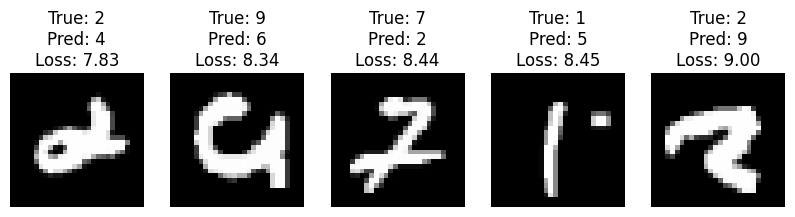

In [72]:
top_losses_vis(vis_params, test_images, test_preds, test_labels, test_losses)

With the confusion matrix for the test set

Accuracy for the entire test set is: 0.9277


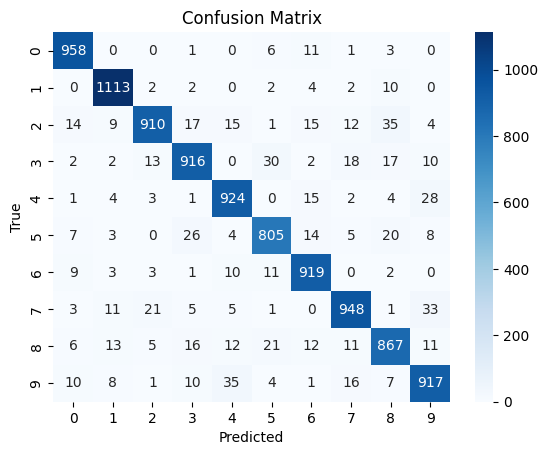

In [67]:
print(f'Accuracy for the entire test set is: {test_acc}')
conf_mat(vis_params['fig_size'])

# Approach \# 2: Hand-designed feature extraction and the following table data classification using the ANN

## Stop logging

In [73]:
task.close()

# Results and discussion

All experiments were performed five times with random seeds of [42, 0, 17, 9, 3] (see the table below). The final metrics were calculated as means and standard deviations over five runs. The minimum values of the loss function on validation determined the best checkpoints of the models (see Figure 1).  

!!! Please implement the experiments, fill the table and plot the figure below. !!!


**Table 1.** Results of a series of simulation experiments on the MNIST dataset comparing two approaches: automatic feature extraction using an artificial neural network (ANN), and a hand-designed feature extractor combined with an ANN classifier.

| # | Approach     | Arch.| #train.param. | Seed | Accuracy, \%|
|---|--------------|------|---------------|------|-------------|
| 1 | Img. classif.| MLP  | 000,000       | 42   | 00.0        |
|   |              |      |               | 0    | 00.0        |
|   |              |      |               | 17   | 00.0        |
|   |              |      |               | 9    | 00.0        |
|   |              |      |               | 3    | 00.0        |
|---|--------------|------|---------------|------|-------------|
| 1 | Tab. classif.| MLP  | 000,000       | 42   | 00.0        |
|   |              |      |               | 0    | 00.0        |
|   |              |      |               | 17   | 00.0        |
|   |              |      |               | 9    | 00.0        |
|   |              |      |               | 3    | 00.0        |

In [74]:
#Enter your code here to plot the figure using Json data from ClearML

**Figure 1.** Comparison of the validation plots for runs with different model initializations (using different seeds).

Summarizing the result, the first (image processing) and the second (hand-designed features processing) approaches demonstrated accuracy of $ 00.0 \pm 0.0$, and $ 00.0 \pm 0.0$, respectively.

# Conclusion

Enter you text here.

Please note that the conclusion is not only a declaration of the obtained results. It should also answer relevant questions related to the work, providing insights that enhance the reader's understanding, make their life a bit easier, and contribute to making the world a bit better — or at least a bit clearer.


# Questions for discussion

* Explain the architecture of the MLP model used in this lab. What are the dimensions of the input layer, hidden layers, and output layer? Why is the input size `28 * 28` for the MNIST dataset?
* What loss function is used in this lab, and why is it suitable for this task? Which optimizer is used, and what is its learning rate?
* What transformations are applied to the MNIST dataset before training? Why is normalization important, and what values are used for normalization in this lab?
* Are the models prone to overfitting? Was this possibility considered and addressed during the modeling process?
* How is accuracy calculated during the testing phase? What does the confusion matrix represent, and how can it help in evaluating the model's performance?
* What does the "Top Losses" visualization represent? How can it help in debugging or improving the model?


## Bonus Questions (Optional)
* What is the purpose of using ClearML in this lab? How does it help in managing machine learning experiments, in general?
